In [11]:
# import libraries
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib notebook


## Prepare Data

In [2]:
batch_size = 64
num_workers = 0
valid_size = 0.2

#data augmentation and data conversion to torch tensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.Pad(padding=5), #add pad and then randomCrop the image
    transforms.RandomCrop(28),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])      
# load the training nad test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# # prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

(1, 28, 28)


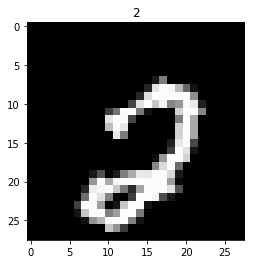

In [5]:
# Visualize the data
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


plt.imshow(np.squeeze(images[22]), cmap='gray')
plt.title(str(labels[22].item()))
print(images[22].shape)

## Define model architecture

In [6]:

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2, stride=1)
        # convolutional layer (sees 28x28x32 image tensor)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2, stride=1)
        # MaxPool(2x2) Dropout(0.25)
        
        # convolutional layer (sees 14x14x32 image tensor) 
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        # convolutional layer (sees 14x14x64 image tensor) 
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        #maxPool(2,2) dropout(0.25)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3136, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # add sqquence of convolution and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        # flatten image input
        x = x.view(-1, 64*7*7)
        
        # add hidden layers with relu
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
# create a model
model = Cnn()
print(model)

Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [7]:
# move tensors to gpu
model.cuda()

Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [8]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
class LivePlot():
    """Class to live plotting accuracy and loss during model training"""
    def __init__(self, fig, n_epochs):
        #initialize matplotlib figure
        self.n_epochs = n_epochs
        self.fig = fig
        self.ax_loss = fig.add_subplot(2, 1, 1)
        self.ax_acc = fig.add_subplot(2, 1, 2)
       
        plt.ion()
        self.fig.show()
        self.fig.canvas.draw()
        
    def plot_model_loss(self, train_loss, valid_loss):
         #Plot Loss    
        self.ax_loss.clear()
        self.ax_loss.plot(train_loss, label='training loss')
        self.ax_loss.plot(valid_loss, label='validation loss')
        self.ax_loss.set_xlabel('epochs')
        self.ax_loss.set_ylabel('loss')
        self.ax_loss.set_title('Model Loss')
        self.ax_loss.legend(loc="upper right")
        self.ax_loss.set_xlim(0, self.n_epochs+1)
        self.ax_loss.set_ylim(0, 0.25)
        fig.canvas.draw()
    
    def plot_model_accuracy(self, train_accuracy, valid_accuracy):
        #Plot acc    
        self.ax_acc.clear()
        self.ax_acc.plot(train_accuracy, label='training accuracy')
        self.ax_acc.plot(valid_accuracy, label='validation accuracy')
        self.ax_acc.set_xlabel('epochs')
        self.ax_acc.set_ylabel('accuracy')
        self.ax_acc.set_title('Model Accuracy')
        self.ax_acc.legend(loc='lower right')
        self.ax_acc.set_xlim(0, self.n_epochs+1)
        plt.tight_layout()
        self.fig.canvas.draw()

        

## Train Model

<IPython.core.display.Javascript object>


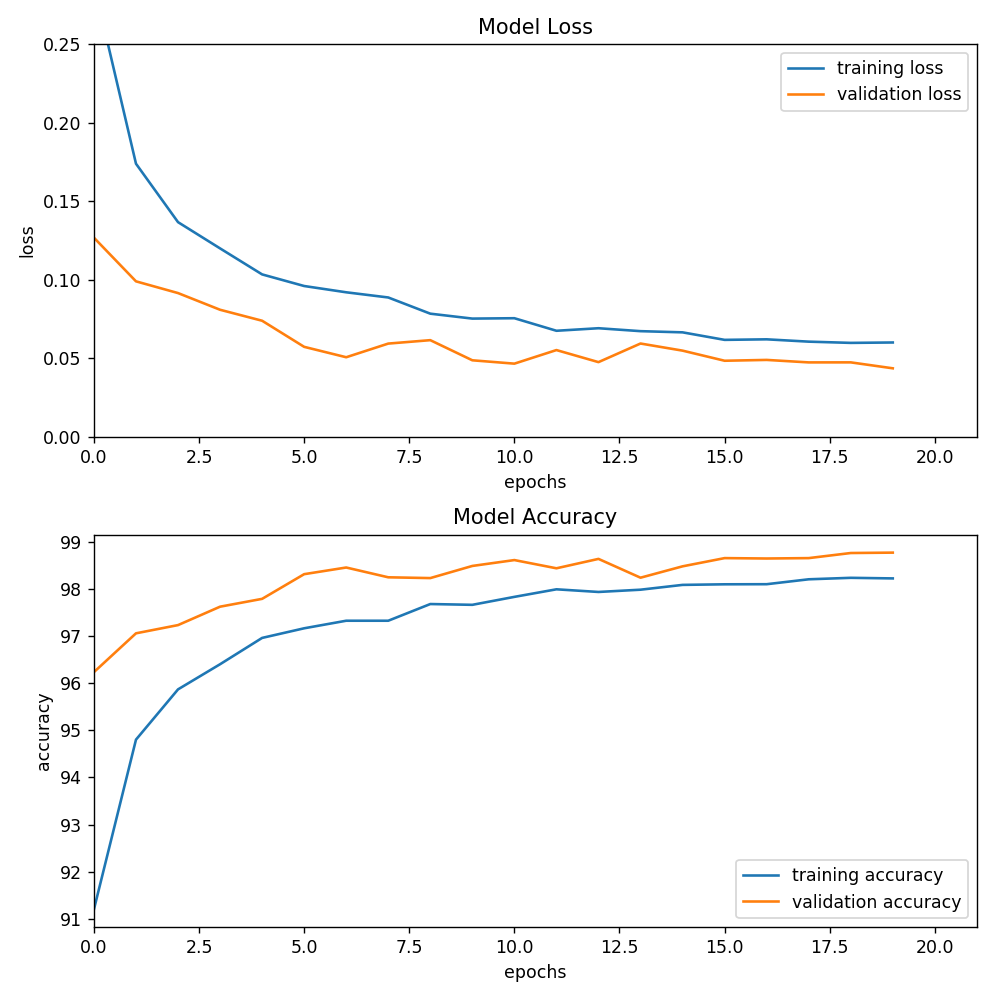

Epoch: 1 	Training Loss: 0.288109 	Validation Loss: 0.126678 
		Training Acc: 91.202083 	Validation Acc: 96.235040
Validation loss decreased (inf --> 0.126678).  Saving model ...
Epoch: 2 	Training Loss: 0.173831 	Validation Loss: 0.098878 
		Training Acc: 94.802083 	Validation Acc: 97.057846
Validation loss decreased (0.126678 --> 0.098878).  Saving model ...
Epoch: 3 	Training Loss: 0.136588 	Validation Loss: 0.091403 
		Training Acc: 95.868750 	Validation Acc: 97.232380
Validation loss decreased (0.098878 --> 0.091403).  Saving model ...
Epoch: 4 	Training Loss: 0.119868 	Validation Loss: 0.080771 
		Training Acc: 96.402083 	Validation Acc: 97.623005
Validation loss decreased (0.091403 --> 0.080771).  Saving model ...
Epoch: 5 	Training Loss: 0.103299 	Validation Loss: 0.073779 
		Training Acc: 96.960417 	Validation Acc: 97.789229
Validation loss decreased (0.080771 --> 0.073779).  Saving model ...
Epoch: 6 	Training Loss: 0.095902 	Validation Loss: 0.057146 
		Training Acc: 97.1645

In [12]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss
training_loss_history = []
validation_loss_history = []
training_acc_history = []
validation_acc_history = []

fig = plt.figure(figsize=(8, 8))
live_plots = LivePlot(fig, n_epochs)


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    
    train_batches_acc = []
    validation_batches_acc = []
    
    # train the model 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
       
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #calculate batch accuracy
        _, pred = torch.max(output, 1) 
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        train_batches_acc.append(100*correct.sum()/data.size(0))        
   
    # validate the model 
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        #calculate batch accuracy
        _, pred = torch.max(output, 1) 
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        validation_batches_acc.append(100*correct.sum()/data.size(0))
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # calculate average accuracy
    valid_acc = np.mean(np.array(validation_batches_acc))
    train_acc = np.mean(np.array(train_batches_acc))
    
    training_loss_history.append(train_loss)
    validation_loss_history.append(valid_loss)
    training_acc_history.append(train_acc)
    validation_acc_history.append(valid_acc)
    
    live_plots.plot_model_loss(training_loss_history, validation_loss_history)
    live_plots.plot_model_accuracy(training_acc_history, validation_acc_history)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_acc, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'digit_recognizer_cnn_model.pt')
        valid_loss_min = valid_loss

## Load the best Model

In [13]:
model.load_state_dict(torch.load('digit_recognizer_cnn_model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Test Model

In [14]:
test_loss = 0.0
test_accuracy = 0.0

model.cuda()
model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
        
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
        
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    test_loss += loss.item()*data.size(0)
        
    #calculate batch accuracy
    _, pred = torch.max(output, 1) 
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    #validation_batches_acc.append(100*)
    test_accuracy += correct.sum()/data.size(0)

test_loss = test_loss/len(test_loader.sampler)
test_accuracy = test_accuracy/len(test_loader)*100

print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.2f}\n'.format(test_accuracy))


Test Loss: 0.031074

Test Accuracy: 99.01



<IPython.core.display.Javascript object>


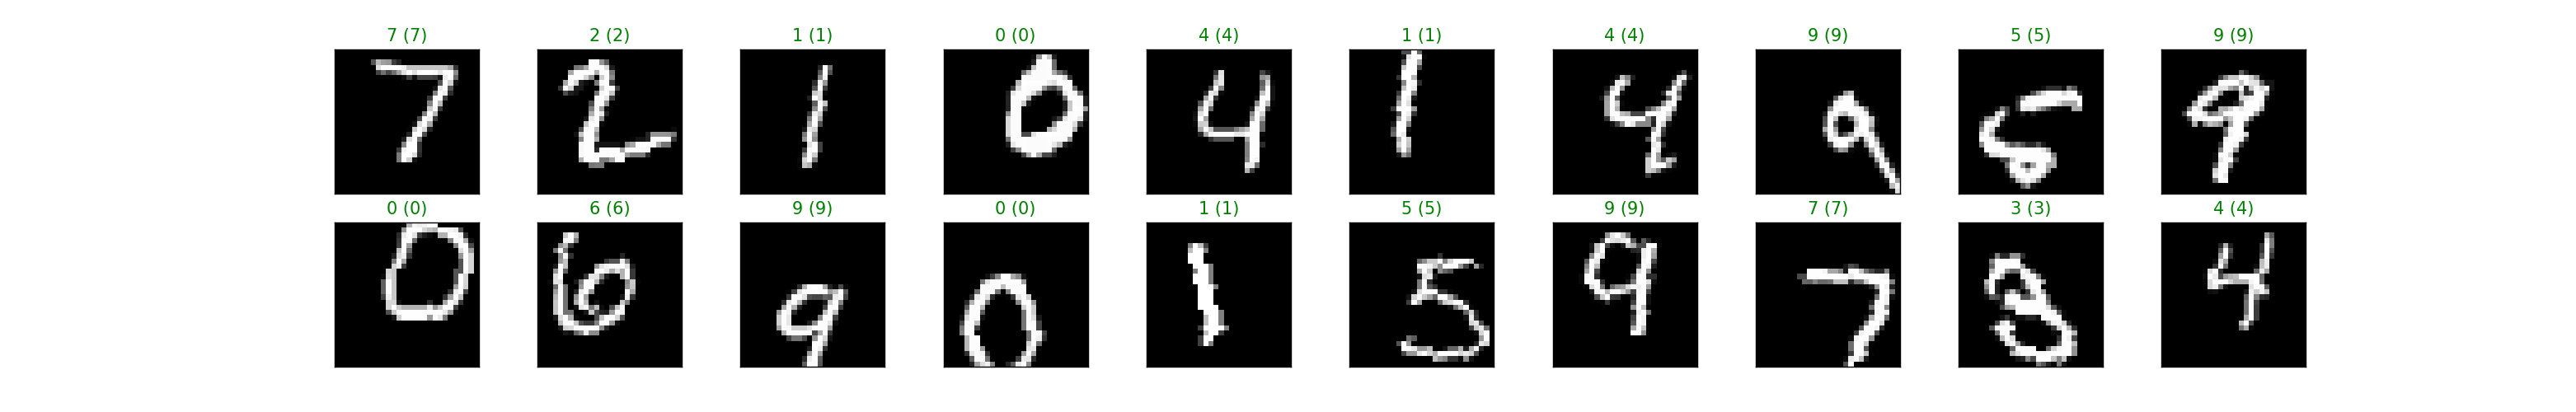

In [15]:
model.cpu()
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))